# 等离子体波动分析

In [2]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import plasmapy
import scipy.signal
import scipy.optimize as op
%config InlineBackend.figure_format = 'svg'

# Function definition

In [3]:
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.dispersion.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs(a-b)/b
    return r

## Parameters settings

In [12]:
k = 0.5
L = 2*np.pi/k
num = 8.e5  # 粒子数
tem = 1  # 温度

vmax = 5. # 速度最大值
max_steps = 1000  # 最大时间步数
q = np.sqrt(L/num)
v_th = np.sqrt(2*tem)
dt = 0.1
path = '../../data/'
d = 0.1
# 等离子体参量
l_D = np.sqrt(tem) # $\lambda_D^2$
w_pe = np.sqrt(1.0)

## Dispersion
$$1 + \frac{1}{ k^2 \lambda_D^2 } [1+\zeta Z(\zeta)]=0$$
- 其中$\zeta=\frac{\omega}{kv_{th}}$，$v_{th}=\sqrt{\frac{2kT}{m_e}}$

In [13]:
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
w_theo = s.x[0]
r_theo = s.x[1]
print("w_theo = ",w_theo)
print("r_theo = ",r_theo)
print("1/r_theo = ", abs(1.0/r_theo))
print("bouns time", 1.0/np.sqrt(q*d*k))

k =  0.5
w_theo =  1.4156618886035603
r_theo =  -0.1533594669236515
1/r_theo =  6.520627777728519
bouns time 71.03706809856611


In [14]:
kvec = np.arange(.1,1.2,0.1)
table = PrettyTable(['k','k*l_D','w_r','w_i','v_p/v_th'])
for ki in kvec:
    s=op.root(lambda w:eq4PDRM(w,ki),[1,0.1])
    vp2vth=s.x[0]/ki/v_th
    ki4p=round(ki,6)
    kl4p=round(ki*l_D,6)
    wr4p=round(s.x[0],6)
    wi4p=round(s.x[1],6)
    vp4p=round(vp2vth,6)
    table.add_row([ki4p,kl4p,wr4p,wi4p,vp4p])
print(table)

+-----+-------+----------+-----------+----------+
|  k  | k*l_D |   w_r    |    w_i    | v_p/v_th |
+-----+-------+----------+-----------+----------+
| 0.1 |  0.1  | 1.015198 |    -0.0   | 7.178531 |
| 0.2 |  0.2  | 1.063984 |  -5.5e-05 | 3.761753 |
| 0.3 |  0.3  | 1.159846 |  -0.01262 | 2.733784 |
| 0.4 |  0.4  | 1.285057 | -0.066128 | 2.271681 |
| 0.5 |  0.5  | 1.415662 | -0.153359 | 2.002048 |
| 0.6 |  0.6  | 1.545707 |  -0.26411 | 1.821633 |
| 0.7 |  0.7  | 1.673866 | -0.392401 | 1.69086  |
| 0.8 |  0.8  | 1.799899 | -0.534552 | 1.590901 |
| 0.9 |  0.9  | 1.923865 | -0.688109 | 1.511531 |
| 1.0 |  1.0  | 2.045905 |  -0.85133 | 1.446673 |
| 1.1 |  1.1  | 2.166175 | -1.022919 | 1.39247  |
+-----+-------+----------+-----------+----------+


In [48]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))
dataep = np.loadtxt(os.path.join(path,"pot_energy"))
dataek = np.loadtxt(os.path.join(path,"kin_energy"))

t = np.linspace(0, max_steps, max_steps+1)

In [49]:
indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[0:3:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
# Ep ~ E^2 ~ Exp(i 2 w t + 2 r t)
w_sim = 2*np.pi/per_sim/2
r_sim = para[0]/dt/2
wc_table=PrettyTable(['w_theo','w_sim','err w(%)','r_theo','r_sim','err r(%)'])
wc_table.add_row([w_theo,w_sim,errPercent(w_sim,w_theo)*100,r_theo,r_sim,errPercent(r_sim,r_theo)*100])
print(wc_table)

+--------------------+-------------------+--------------------+---------------------+----------------------+---------------------+
|       w_theo       |       w_sim       |      err w(%)      |        r_theo       |        r_sim         |       err r(%)      |
+--------------------+-------------------+--------------------+---------------------+----------------------+---------------------+
| 1.4156618886035603 | 1.427996660722633 | 0.8713077761272525 | -0.1533594669236515 | -0.15450213686628897 | -0.7450925368737412 |
+--------------------+-------------------+--------------------+---------------------+----------------------+---------------------+


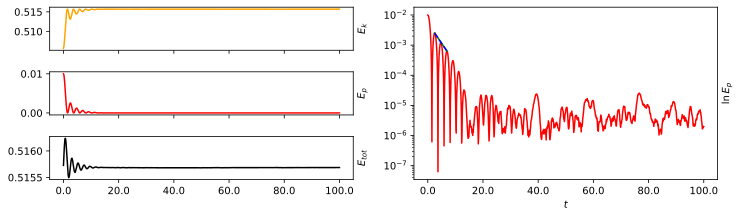

In [50]:
fig = plt.figure(figsize=(12, 3))
time_ticks = np.linspace(0,max_steps,num=6)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")
plt.xticks(time_ticks,[])

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")
plt.xticks(time_ticks,[])

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")
plt.xticks(time_ticks,time_ticks*dt)

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.plot(xep,np.exp(line(para,xep)), '-',color='green')
axl2.plot(xep,np.exp(r_sim*xep*dt*2+para[1]), '--',color='blue')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")
plt.xticks(time_ticks,time_ticks*dt)

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()